# Protein Crystals Data

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

import pandas as pd
import optuna
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from ANFISpy import ANFIS
from ANFISpy import ProdAND

## Dataset

Loading data.

In [2]:
SEED = 42
torch.manual_seed(SEED)

df = pd.read_excel('protein_data.xlsx')
df = df.dropna()

FEATURES = ["Concentração de proteína (em mg/mL)", "Concentração de sal (em mg/mL)"]
TARGET = ["Definicação do cristal"]

x = df[FEATURES].values.astype('float16')
y = df[TARGET].values.astype('float16')
y = np.clip(np.rint(y), 0, 2)

unique_x, inverse_indices = np.unique(x, axis=0, return_inverse=True)

most_frequent_y = []
for idx in range(len(unique_x)):
    group_y = y[inverse_indices == idx]
    most_common = stats.mode(group_y, keepdims=False).mode
    most_frequent_y.append(most_common)

most_frequent_y = np.array(most_frequent_y).astype(int).squeeze()

x = torch.tensor(unique_x, dtype=torch.float32)
y = torch.tensor(most_frequent_y, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,      
    random_state=SEED,
    stratify=y    
)

x_max = x_train.max(dim=0, keepdim=True)[0]
x_min = x_train.min(dim=0, keepdim=True)[0]
x_train = (x_train - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

BATCH_SIZE = 4

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

class_counts = torch.bincount(y_train)
weights = 1.0 / class_counts.float()
sample_weights = weights[y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=2*len(y_train), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Analysing Optuna.

In [3]:
df = pd.read_csv('anfis_optuna.csv')
df.sort_values('value', ascending=False).head(1)

,number,value,datetime_start,datetime_complete,duration,params_and_operator,params_lr,params_n_sets_protein,params_n_sets_salt,params_shape,state
41,41,0.86,2025-10-01 11:10:42.630482,2025-10-01 11:11:00.094165,0 days 00:00:17.463683,prod,0.000276,3,4,bell,COMPLETE


Training ANFIS.

In [4]:
n_vars = 2
variables = {
    'inputs': {
        'n_sets': [3, 4],
        'uod': n_vars * [(0, 1)],
        'var_names': ['C_p', 'C_s'],
        'mf_names': [['L', 'M', 'H'], ['L', 'ML', 'MH', 'H']],
    },
    'output': {
        'var_names': 'Cristal Quality',
        'n_classes': 3,
    },
}

anfis = ANFIS(
    variables,
    'bell',
    and_operator=ProdAND(),
    output_activation=nn.Identity(),
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anfis.parameters(), lr=0.000276)

try:
    anfis.load_state_dict(torch.load('anfis.pth', map_location='cpu', weights_only=True))
    print('Loaded')
    
except:
    epochs = 100
    for epoch in range(epochs):
        anfis.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = anfis(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

    torch.save(anfis.state_dict(), 'anfis.pth')
    print('Saved')
    
anfis.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    preds = anfis(x_test)
    preds = preds.argmax(dim=1)
    all_preds.append(preds)
    all_labels.append(y_test)

all_preds_anfis = torch.cat(all_preds)
all_labels_anfis = torch.cat(all_labels)

print(classification_report(all_labels_anfis, all_preds_anfis))

Loaded
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5

    accuracy                           0.85        13
   macro avg       0.87      0.87      0.87        13
weighted avg       0.85      0.85      0.85        13



Doing the same for the MLP.

In [5]:
df = pd.read_csv('mlp_optuna.csv')
df.sort_values('value', ascending=False).head(1)

,number,value,datetime_start,datetime_complete,duration,params_activation,params_hidden_dim,params_lr,params_n_layers,state
498,498,0.86,2025-10-01 14:41:15.070693,2025-10-01 14:41:24.336104,0 days 00:00:09.265411,relu,28,0.000676,3,COMPLETE


In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, activation):
        super(MLP, self).__init__()
        layers = []

        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation)
        
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)

        layers.append(nn.Linear(hidden_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

mlp = MLP(2, 28, 3, 3, nn.ReLU())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.000676)

try:
    mlp.load_state_dict(torch.load('mlp.pth', map_location='cpu', weights_only=True))
    print('Loaded')
    
except:
    epochs = 100
    for epoch in range(epochs):
        mlp.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = mlp(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

    torch.save(mlp.state_dict(), 'mlp.pth')
    print('Saved')
    
mlp.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    preds = mlp(x_test)
    preds = preds.argmax(dim=1)
    all_preds.append(preds)
    all_labels.append(y_test)

all_preds_mlp = torch.cat(all_preds)
all_labels_mlp = torch.cat(all_labels)

print(classification_report(all_labels_mlp, all_preds_mlp))

Loaded
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.80      0.80      0.80         5
           2       0.75      0.60      0.67         5

    accuracy                           0.77        13
   macro avg       0.77      0.80      0.77        13
weighted avg       0.77      0.77      0.76        13



## Plots

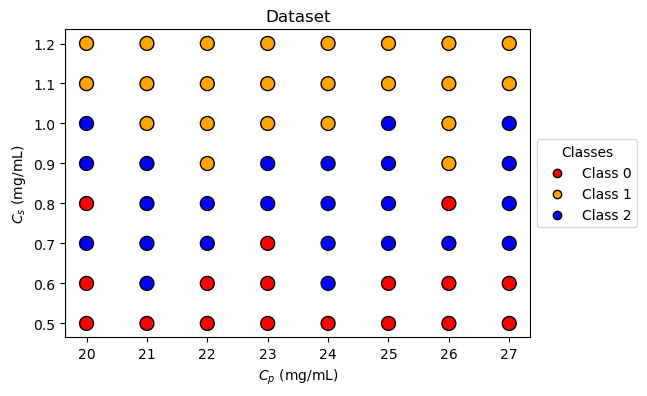

In [7]:
color_map = {
    0: 'red',
    1: 'orange',
    2: 'blue'
}

most_frequent_y = most_frequent_y.ravel().astype('uint8')

colors = [color_map[label] for label in most_frequent_y]

plt.figure(figsize=(6, 4))
plt.scatter(unique_x[:, 0], unique_x[:, 1], c=colors, s=100, edgecolor='k')

plt.ylabel(r'$C_s$ (mg/mL)')
plt.xlabel(r'$C_p$ (mg/mL)')
plt.title('Dataset')

for label, color in color_map.items():
    plt.scatter([], [], color=color, edgecolor='k', label=f'Class {label}')
plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

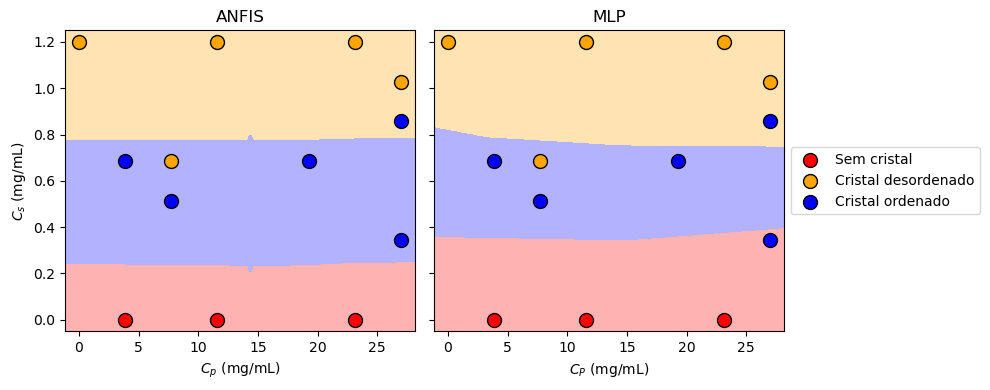

In [8]:
padding = 0.04
xlim_min, xlim_max = 0 - padding, 1 + padding
ylim_min, ylim_max = 0 - padding, 1 + padding

xx, yy = np.meshgrid(
    np.linspace(xlim_min, xlim_max, 300),
    np.linspace(ylim_min, ylim_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

color_map = {0: 'red', 1: 'orange', 2: 'blue'}
cmap = ListedColormap(['red', 'orange', 'blue'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

anfis.eval()
with torch.no_grad():
    preds_anfis = anfis(grid_tensor)
    preds_anfis = torch.argmax(preds_anfis, dim=1).numpy()

axes[0].pcolormesh(xx * 27, yy * 1.2, preds_anfis.reshape(xx.shape), cmap=cmap, shading='auto', alpha=0.3)

for label in np.unique(y_test.numpy()):
    axes[0].scatter(
        (x_test[:, 0] * 27)[y_test == label].numpy(),
        (x_test[:, 1] * 1.2)[y_test == label].numpy(),
        color=color_map[label],
        label=f'Class {label}',
        s=100,
        edgecolor='k'
    )

axes[0].set_title('ANFIS')
axes[0].set_ylabel(r'$C_s$ (mg/mL)')
axes[0].set_xlabel(r'$C_p$ (mg/mL)')

mlp.eval()
with torch.no_grad():
    preds_mlp = mlp(grid_tensor)
    preds_mlp = torch.argmax(preds_mlp, dim=1).numpy()

axes[1].pcolormesh(xx * 27, yy * 1.2, preds_mlp.reshape(xx.shape), cmap=cmap, shading='auto', alpha=0.3)

labels = ['Sem cristal', 'Cristal desordenado', 'Cristal ordenado']

for i, label in enumerate(np.unique(y_test.numpy())):
    axes[1].scatter(
        (x_test[:, 0] * 27)[y_test == label].numpy(),
        (x_test[:, 1] * 1.2)[y_test == label].numpy(),
        color=color_map[label],
        label=labels[i],
        s=100,
        edgecolor='k'
    )

axes[1].set_title('MLP')
axes[1].set_xlabel(r'$C_P$ (mg/mL)')

axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

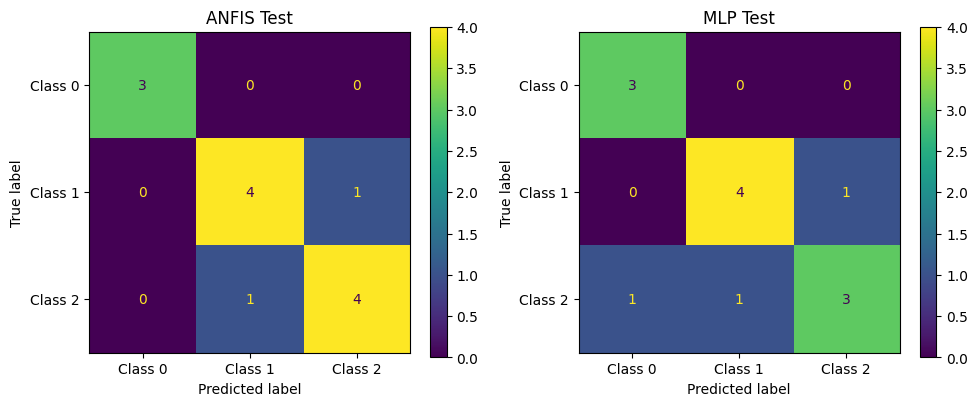

In [9]:
anfis.eval()
mlp.eval()

with torch.no_grad():
    anfis_logits = anfis(x_test)
    anfis_preds = torch.argmax(anfis_logits, dim=1).numpy()
    
    mlp_logits = mlp(x_test)
    mlp_preds = torch.argmax(mlp_logits, dim=1).numpy()

y_true = y_test.numpy()

cm_anfis = confusion_matrix(y_true, anfis_preds)
cm_mlp = confusion_matrix(y_true, mlp_preds)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp_anfis = ConfusionMatrixDisplay(
    confusion_matrix=cm_anfis, 
    display_labels=['Class 0', 'Class 1', 'Class 2'],
)
disp_anfis.plot(ax=axes[0], values_format='d')
axes[0].set_title('ANFIS Test')
axes[0].grid(False)

disp_mlp = ConfusionMatrixDisplay(
    confusion_matrix=cm_mlp,                            
    display_labels=['Class 0', 'Class 1', 'Class 2']
)
disp_mlp.plot(ax=axes[1], values_format='d')
axes[1].set_title('MLP Test')

plt.tight_layout()
plt.show()

## Instance explanation

In [10]:
n_classes = 3

act = anfis.rule_activations(x_test).detach()
rules = anfis.print_rules()

print('Target')
print(y_test.numpy())
print()
print('ANFIS')
print(anfis_preds)

Target
[0 2 2 0 2 2 1 1 0 1 1 2 1]

ANFIS
[0 2 1 0 2 2 1 1 0 2 1 2 1]


Local explanation with target 0.

In [11]:
idx_target0 = act[0].numpy().argmax().item()

for i in range(n_classes):
    print(rules[n_classes * idx_target0 + i])
    print()

Rule 0 (Cristal Quality): IF C_p IS L AND C_s IS L, THEN f0_0 = (0.79 * C_p) + (-0.11 * C_s) + 0.90

Rule 0 (Cristal Quality): IF C_p IS L AND C_s IS L, THEN f0_1 = (0.64 * C_p) + (0.35 * C_s) - 1.05

Rule 0 (Cristal Quality): IF C_p IS L AND C_s IS L, THEN f0_2 = (-0.69 * C_p) + (0.28 * C_s) - 0.71



Local explanation with target 1.

In [12]:
idx_target1 = act[6].numpy().argmax().item()

for i in range(n_classes):
    print(rules[n_classes * idx_target1 + i])
    print()

Rule 3 (Cristal Quality): IF C_p IS L AND C_s IS H, THEN f3_0 = (-0.97 * C_p) + (-0.19 * C_s) - 0.74

Rule 3 (Cristal Quality): IF C_p IS L AND C_s IS H, THEN f3_1 = (0.91 * C_p) + (0.28 * C_s) + 0.64

Rule 3 (Cristal Quality): IF C_p IS L AND C_s IS H, THEN f3_2 = (0.34 * C_p) + (-0.00 * C_s) - 0.56



Local explanation with target 2.

In [13]:
idx_target2 = act[1].numpy().argmax().item()

for i in range(n_classes):
    print(rules[n_classes * idx_target2 + i])
    print()

Rule 1 (Cristal Quality): IF C_p IS L AND C_s IS ML, THEN f1_0 = (0.23 * C_p) + (-0.01 * C_s) - 0.53

Rule 1 (Cristal Quality): IF C_p IS L AND C_s IS ML, THEN f1_1 = (-0.19 * C_p) + (0.08 * C_s) - 0.97

Rule 1 (Cristal Quality): IF C_p IS L AND C_s IS ML, THEN f1_2 = (0.27 * C_p) + (-0.34 * C_s) + 0.49

